<div>
<img src=https://www.institutedata.com/wp-content/uploads/2019/10/iod_h_tp_primary_c.svg width="300">
</div>

# Mini Project 1
## Analyzing Global Population Census Data Using Google BigQuery API

## Data Overview
The United States Census Bureau’s international dataset provides estimates of country populations since 1950 and projections through 2050. Specifically, the dataset includes midyear population figures broken down by age and gender assignment at birth. Additionally, time-series data is provided for attributes including fertility rates, birth rates, death rates, and migration rates.

*Note: The U.S. Census Bureau provides estimates and projections for countries and areas that are recognized by the U.S. Department of State that have a population of at least 5,000.*

### Setting up connection with Bigquery

In [1]:
from google.cloud import bigquery
from google.cloud.bigquery import Dataset
from google.cloud import storage
from google.cloud import bigquery_storage
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Invoke a method of the `.Client` object that takes the path to your key files as a string argument:

In [2]:
key_path = 'integral-loop-435302-p9-25d78a99b81e.json'
storage_client = storage.Client.from_service_account_json(key_path)

In [3]:
client = bigquery.Client.from_service_account_json(key_path, project = 'integral-loop-435302-p9')

In [4]:
# function for listing datasets in a project:
def printDatasetList(client):
    project = client.project    #: only one project can be associated with a client instance
    datasets = list(client.list_datasets())
    if datasets:
        print('Datasets in project {}:'.format(project))
        for dataset in datasets:
            print('\t{}'.format(dataset.dataset_id))
        found = True
    else:
        print('{} project does not contain any datasets.'.format(project))
        found = False
    return found

In [5]:
# list datasets in the default project:
printDatasetList(client)

Datasets in project integral-loop-435302-p9:
	census_bureau_international


True

In [6]:
#create a dataset reference object by assigning a project and a dataset name
dataset_id = 'census_bureau_international'
dataset_ref = client.dataset(dataset_id)

In [7]:
# function for listing tables in a dataset:
def printTableList(client, dataset_id):
    project = client.project
    dataset_ref = client.dataset(dataset_id, project = project)
    tables = list(client.list_tables(dataset_ref))
    if tables:
        print('Tables in dataset {}:'.format(dataset_id))
        for table in tables:
            print('\t{}'.format(table.table_id))
        found = True
    else:
        print('{} dataset does not contain any tables.'.format(dataset_id))
        found = False
    return found

In [8]:
#Tables in the current dataset
printTableList(client, dataset_id)

Tables in dataset census_bureau_international:
	age_specific_fertility_rates
	birth_death_growth_rates
	country_names_area
	midyear_population
	midyear_population_5yr_age_sex
	midyear_population_age_sex
	midyear_population_agespecific
	mortality_life_expectancy


True

## Analysis and Visualization

### Total Global Population Over Time

In [9]:
#ANSWER
sql = """
SELECT year, SUM(midyear_population) AS total_population
FROM `census_bureau_international.midyear_population`
GROUP BY year
ORDER BY year

"""
query_job = client.query(sql)
total_pop = query_job.to_dataframe()
total_pop

,year,total_population
0,1950,2557628654
1,1951,2594941405
2,1952,2636775398
3,1953,2682058085
4,1954,2730234132
...,...,...
96,2046,9298694001
97,2047,9347762508
98,2048,9395720582
99,2049,9442528336


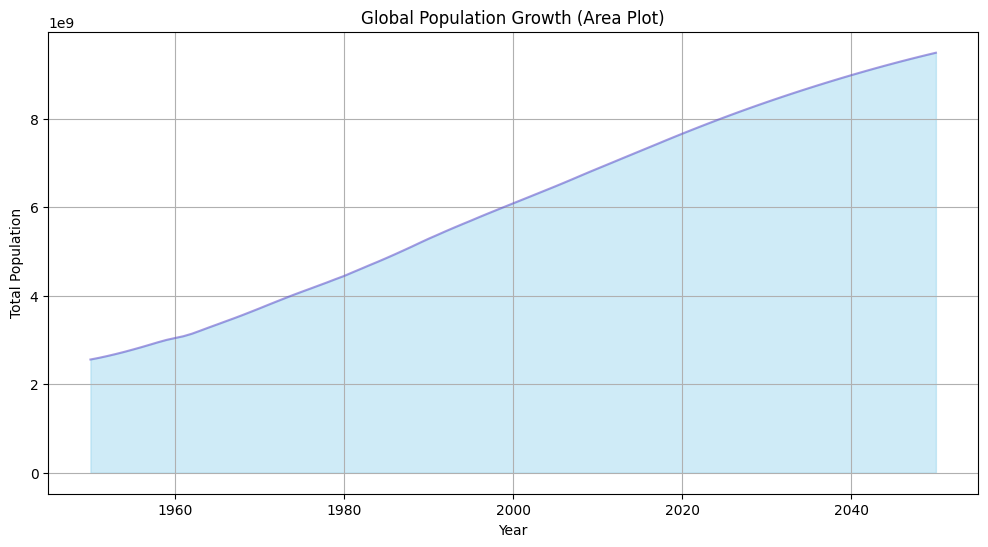

In [10]:
plt.figure(figsize=(12, 6))
plt.fill_between(total_pop['year'], total_pop['total_population'], color="skyblue", alpha=0.4)
plt.plot(total_pop['year'], total_pop['total_population'], color="Slateblue", alpha=0.6)
plt.xlabel('Year')
plt.ylabel('Total Population')
plt.title('Global Population Growth (Area Plot)')
plt.grid(True)
plt.show()

### Top 10 Most Populous Countries in 2024

In [11]:
sql = """
SELECT country_name, midyear_population
FROM `census_bureau_international.midyear_population`
WHERE year = 2024
ORDER BY midyear_population DESC
LIMIT 10
"""
query_job = client.query(sql)
country_population = query_job.to_dataframe() 
country_population

,country_name,midyear_population
0,China,1405710181
1,India,1382464004
2,United States,344814299
3,Indonesia,274900326
4,Nigeria,236615225
5,Pakistan,225461632
6,Brazil,217022513
7,Bangladesh,168804192
8,Russia,140497710
9,Mexico,133662249


### Country-wise Growth Rates

In [223]:
sql = """
SELECT country_name, growth_rate 
FROM `census_bureau_international.birth_death_growth_rates` 
WHERE year = 2024 
ORDER BY growth_rate DESC 
LIMIT 10;
"""
query_job = client.query(sql)
g_rate = query_job.to_dataframe()
g_rate

,country_name,growth_rate
0,South Sudan,4.655
1,Angola,3.331
2,Malawi,3.249
3,Burundi,3.129
4,Chad,3.015
5,Uganda,3.000
6,Niger,2.990
7,Mali,2.898
8,Zambia,2.844
9,Guinea,2.744


### Total Population Vs Country Area with population density

In [22]:
sql = """
SELECT 
    mp.country_name, 
    mp.year, 
    mp.midyear_population, 
    cna.country_area, 
    (mp.midyear_population / cna.country_area) AS population_density
FROM 
    `census_bureau_international.midyear_population` AS mp
JOIN 
    `census_bureau_international.country_names_area` AS cna
ON 
    mp.country_code = cna.country_code
WHERE 
    mp.year = 2024
ORDER BY 
    population_density DESC
"""
query_job = client.query(sql)
density = query_job.to_dataframe()
density

,country_name,year,midyear_population,country_area,population_density
0,Macau,2024,627763,28.2,22261.099291
1,Monaco,2024,31529,2.0,15764.500000
2,Singapore,2024,6630412,709.2,9349.142696
3,Hong Kong,2024,7292871,1073.0,6796.711090
4,Gaza Strip,2024,2080232,360.0,5778.422222
...,...,...,...,...,...
223,Namibia,2024,2828480,823290.0,3.435582
224,Australia,2024,24838374,7682300.0,3.233195
225,Western Sahara,2024,718812,266000.0,2.702301
226,Mongolia,2024,3277423,1553556.0,2.109627


###  Population of a Australia Over Time

In [24]:
sql = """
SELECT year, midyear_population 
FROM `census_bureau_international.midyear_population`
WHERE country_name = 'Australia'
ORDER BY year
"""
query_job = client.query(sql)
aus_pop = query_job.to_dataframe()
aus_pop

,year,midyear_population
0,1950,8267337
1,1951,8510600
2,1952,8691212
3,1953,8857924
4,1954,9064017
...,...,...
96,2046,28519028
97,2047,28645887
98,2048,28770380
99,2049,28892628


### Total fertility rate for each country in 2024, ranked from highest to lowest.

In [26]:
sql = """
SELECT
  country_name,
  total_fertility_rate,
  RANK() OVER (ORDER BY total_fertility_rate DESC) AS rank
FROM `census_bureau_international.age_specific_fertility_rates`
WHERE
  year = 2024;
"""
query_job = client.query(sql)
fert_rate = query_job.to_dataframe()
fert_rate

,country_name,total_fertility_rate,rank
0,Mozambique,4.6430,13
1,Burkina Faso,4.0220,25
2,Guatemala,2.5200,63
3,Paraguay,1.8817,124
4,Guyana,1.8100,142
...,...,...,...
223,"Micronesia, Federated States of",2.1940,84
224,Madagascar,3.4680,34
225,Ecuador,1.9940,104
226,Georgia,1.7476,156


### Fertility Rates Across Age Groups Overtime

In [241]:
sql = """
SELECT year,
       fertility_rate_15_19 AS fertility_rate_15_19,
       fertility_rate_20_24 AS fertility_rate_20_24,
       fertility_rate_25_29 AS fertility_rate_25_29,
       fertility_rate_30_34 AS fertility_rate_30_34,
       fertility_rate_35_39 AS fertility_rate_35_39,
       fertility_rate_40_44 AS fertility_rate_40_44,
       fertility_rate_45_49 AS fertility_rate_45_49
FROM `census_bureau_international.age_specific_fertility_rates`
WHERE country_name = 'Singapore'
ORDER BY year
"""
query_job = client.query(sql)
df = query_job.to_dataframe()
df 

,year,fertility_rate_15_19,fertility_rate_20_24,fertility_rate_25_29,fertility_rate_30_34,fertility_rate_35_39,fertility_rate_40_44,fertility_rate_45_49
0,1990,7.4,44.4,114.9,98.5,40.8,6.9,0.1
1,1991,7.1,40.2,105.3,93.7,38.3,6.1,0.3
2,1992,6.4,39.0,102.2,93.7,38.1,6.5,0.2
3,1993,6.4,36.4,99.1,93.1,39.4,6.7,0.2
4,1994,5.5,33.1,95.1,92.0,38.4,6.3,0.1
...,...,...,...,...,...,...,...,...
56,2046,4.8,16.3,56.0,93.6,51.5,8.3,0.4
57,2047,4.8,16.4,56.6,94.5,52.0,8.4,0.4
58,2048,4.9,16.6,57.1,95.4,52.5,8.5,0.5
59,2049,4.9,16.8,57.7,96.4,53.0,8.5,0.5


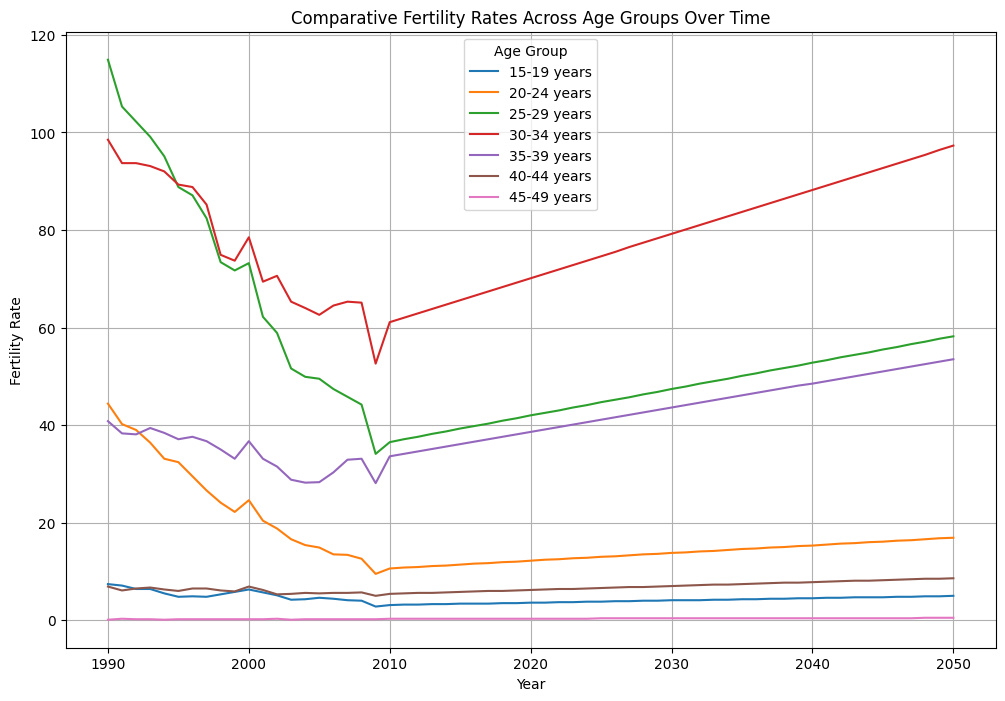

In [243]:
plt.figure(figsize=(12, 8))

plt.plot(df['year'], df['fertility_rate_15_19'],  label='15-19 years')
plt.plot(df['year'], df['fertility_rate_20_24'],  label='20-24 years')
plt.plot(df['year'], df['fertility_rate_25_29'],  label='25-29 years')
plt.plot(df['year'], df['fertility_rate_30_34'],  label='30-34 years')
plt.plot(df['year'], df['fertility_rate_35_39'],  label='35-39 years')
plt.plot(df['year'], df['fertility_rate_40_44'],  label='40-44 years')
plt.plot(df['year'], df['fertility_rate_45_49'],  label='45-49 years')

# Customize the plot
plt.title('Comparative Fertility Rates Across Age Groups Over Time')
plt.xlabel('Year')
plt.ylabel('Fertility Rate')
plt.legend(title='Age Group')
plt.grid(True)

# Show the plot
plt.show()


### Correlation Between Fertility and Infant Mortality rate


In [28]:
sql = """
SELECT 
    afr.country_name, 
    afr.year, 
    afr.total_fertility_rate, 
    mle.infant_mortality
FROM 
    `census_bureau_international.age_specific_fertility_rates` AS afr
JOIN 
    `census_bureau_international.mortality_life_expectancy` AS mle
ON 
    afr.country_name = mle.country_name AND afr.year = mle.year
WHERE 
    afr.year = 2020
ORDER BY 
    afr.country_name;
"""
query_job = client.query(sql)
infmort = query_job.to_dataframe()
infmort

,country_name,year,total_fertility_rate,infant_mortality
0,Afghanistan,2020,4.8200,104.25
1,Albania,2020,1.5293,10.83
2,Algeria,2020,2.5852,17.57
3,American Samoa,2020,2.3500,9.90
4,Andorra,2020,1.4293,3.50
...,...,...,...,...
223,West Bank,2020,3.0700,12.78
224,Western Sahara,2020,3.6500,47.93
225,Yemen,2020,3.2000,41.92
226,Zambia,2020,5.4900,55.97


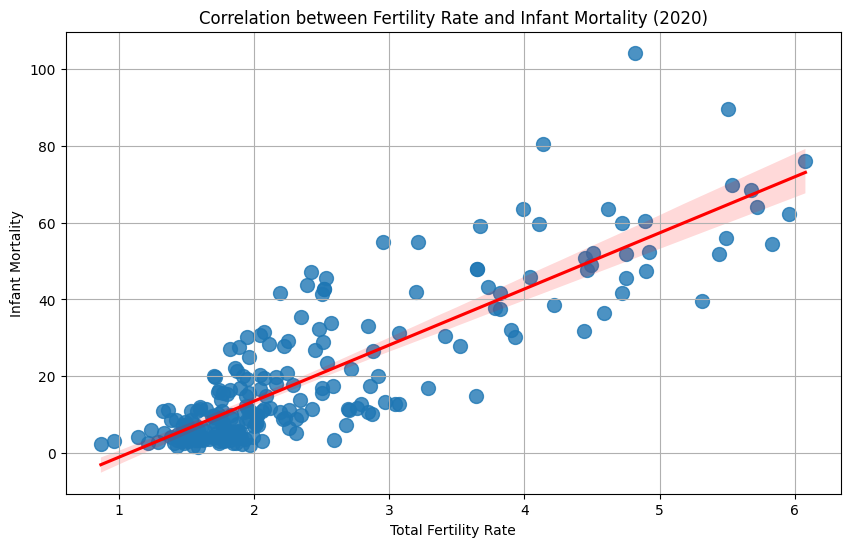

In [29]:
plt.figure(figsize=(10, 6))

# Scatter plot with a regression line
sns.regplot(x='total_fertility_rate', y='infant_mortality', data=infmort, scatter_kws={'s':100}, line_kws={'color':'red'})
plt.title('Correlation between Fertility Rate and Infant Mortality (2020)')
plt.xlabel('Total Fertility Rate')
plt.ylabel('Infant Mortality')
plt.grid(True)

plt.show()

### Global Life Expectancy Over Time

In [31]:
sql = """
SELECT year, AVG(life_expectancy) AS avg_life_expectancy
FROM census_bureau_international.mortality_life_expectancy
GROUP BY year
ORDER BY year
"""
query_job = client.query(sql)
life_ex = query_job.to_dataframe()
life_ex

,year,avg_life_expectancy
0,1950,42.370000
1,1951,42.565000
2,1952,42.720000
3,1953,42.776667
4,1954,42.913333
...,...,...
96,2046,78.717763
97,2047,78.871930
98,2048,79.024211
99,2049,79.174167


### Population Distribution by Age Group for Australia

In [229]:
sql = """
SELECT starting_age, ending_age, SUM(midyear_population) AS population
FROM `census_bureau_international.midyear_population_5yr_age_sex`
WHERE country_name = 'Australia' AND year = 2024
GROUP BY starting_age, ending_age
ORDER BY starting_age
"""
query_job = client.query(sql)
pop_dis = query_job.to_dataframe()
pop_dis

,starting_age,ending_age,population
0,0,0,24838374
1,0,4,1446572
2,5,9,1443290
3,10,14,1433918
4,15,19,1464154
5,20,24,1539312
6,25,29,1678438
7,30,34,1776769
8,35,39,1732612
9,40,44,1670119


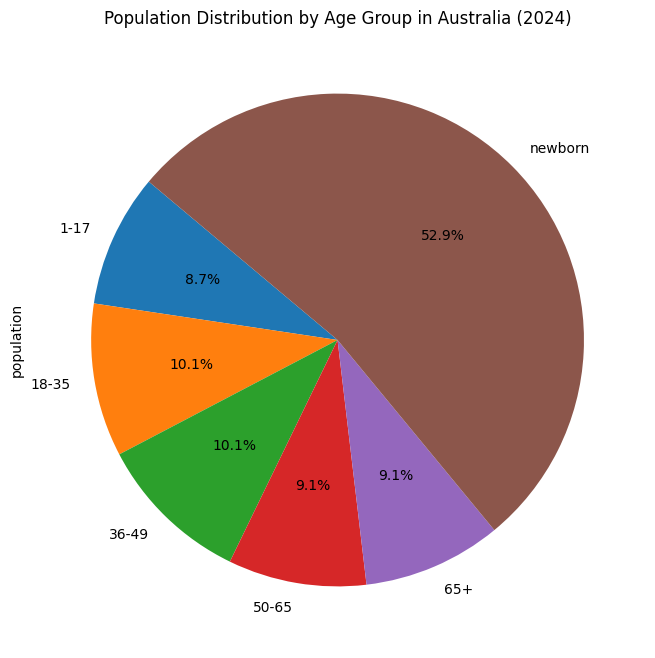

In [245]:
def categorize_age(starting_age):
    if starting_age == 0:
        return 'newborn'
    elif starting_age < 18:
        return '1-17'
    elif starting_age < 35:
        return '18-35'
    elif starting_age < 50:
        return '36-49'
    elif starting_age < 64:
        return '50-65'
    else:
        return '65+'

pop_dis['age_group'] = pop_dis['starting_age'].apply(categorize_age)
age_group_pop = pop_dis.groupby('age_group')['population'].sum()

# Plot pie chart
age_group_pop.plot.pie(autopct='%1.1f%%', startangle=140, figsize=(8, 8), title='Population Distribution by Age Group in Australia (2024)')
plt.show()

### Population by Age Group and Sex


In [127]:
sql = """
SELECT country_name, year, sex, age, SUM(population) AS total_population
FROM census_bureau_international.midyear_population_agespecific
GROUP BY country_name, year, sex, age
ORDER BY country_name, year, sex, age;
"""
query_job = client.query(sql)
pop_dis1 = query_job.to_dataframe()
pop_dis1


,country_name,year,sex,age,total_population
0,Afghanistan,1979,Female,0,299276
1,Afghanistan,1979,Female,1,284224
2,Afghanistan,1979,Female,2,270908
3,Afghanistan,1979,Female,3,258667
4,Afghanistan,1979,Female,4,247496
...,...,...,...,...,...
3040297,Zimbabwe,2050,Male,96,432
3040298,Zimbabwe,2050,Male,97,288
3040299,Zimbabwe,2050,Male,98,185
3040300,Zimbabwe,2050,Male,99,116


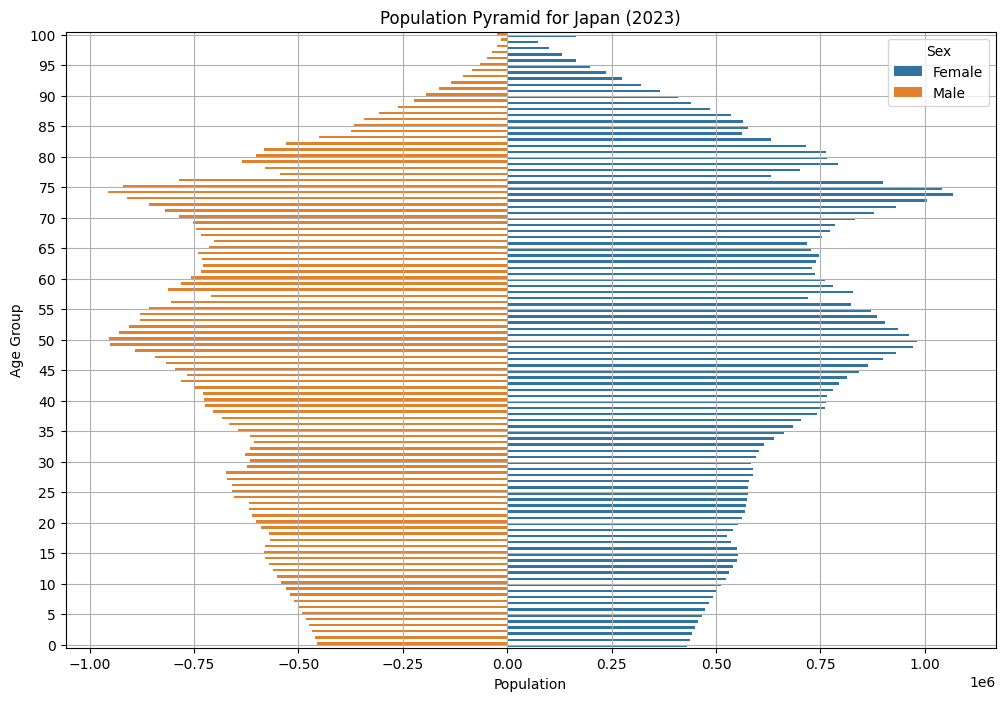

In [253]:
country = 'Japan'
year = 2023
data = pop_dis1[(pop_dis1['country_name'] == country) & (pop_dis1['year'] == year)]
# Prepare the data for plotting
data.loc[data['sex'] == 'Male', 'total_population'] = -data['total_population'] 

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(x='total_population', y='age', hue='sex', data=data, orient='h')

# Customize plot
plt.title(f'Population Pyramid for {country} ({year})')
plt.xlabel('Population')
plt.ylabel('Age Group')
plt.legend(title='Sex')
plt.grid(True)
plt.yticks(ticks=data['age'].unique()[::5])
plt.gca().invert_yaxis()

plt.show()

## Birth Rate vs. Death

In [38]:
sql = """
SELECT country_name, crude_birth_rate, crude_death_rate
FROM `census_bureau_international.birth_death_growth_rates`
WHERE year = 2020
ORDER BY country_name
"""
query_job = client.query(sql)
birthvsdeath = query_job.to_dataframe()
birthvsdeath



,country_name,crude_birth_rate,crude_death_rate
0,Afghanistan,36.67,12.70
1,Albania,13.04,7.12
2,Algeria,19.99,4.35
3,American Samoa,17.80,5.89
4,Andorra,6.98,7.68
...,...,...,...
223,West Bank,25.17,3.43
224,Western Sahara,27.96,7.68
225,Yemen,25.80,5.64
226,Zambia,40.43,11.59


### Which countries are seeing the largest net migration?

In [186]:
sql = """
SELECT
  growth.country_name,
  growth.net_migration,
  CAST(area.country_area AS INT64) AS country_area
FROM (
  SELECT
    country_name,
    net_migration,
    country_code
  FROM
    `bigquery-public-data.census_bureau_international.birth_death_growth_rates`
  WHERE
    year = 2024) growth
INNER JOIN (
  SELECT
    country_area,
    country_code
  FROM
    `bigquery-public-data.census_bureau_international.country_names_area`
  WHERE
    country_area > 500) area
ON
  growth.country_code = area.country_code
ORDER BY
  net_migration DESC
LIMIT
  10
"""
query_job = client.query(sql)
mig = query_job.to_dataframe()
mig

,country_name,net_migration,country_area
0,South Sudan,19.06,644329
1,Luxembourg,10.80,2586
2,Singapore,10.27,709
3,United Arab Emirates,8.32,83600
4,Turks and Caicos Islands,8.30,948
5,Saudi Arabia,6.72,2149690
6,Cyprus,6.35,9241
7,Spain,6.06,498980
8,Canada,5.69,9093507
9,Sweden,5.05,410335


### Which countries have the largest population under 25?

In [158]:
sql = """
SELECT
  age.country_name,
  SUM(age.population) AS under_25,
  pop.midyear_population AS total,
  ROUND((SUM(age.population) / pop.midyear_population) * 100,2) AS percentage
FROM (
  SELECT
    country_name,
    population,
    country_code
  FROM
    `bigquery-public-data.census_bureau_international.midyear_population_agespecific`
  WHERE
    year =2017
    AND age < 25) age
INNER JOIN (
  SELECT
    midyear_population,
    country_code
  FROM
    `bigquery-public-data.census_bureau_international.midyear_population`
  WHERE
    year = 2017) pop
ON
  age.country_code = pop.country_code
GROUP BY
  1,
  3
ORDER BY
  percentage DESC
LIMIT
  10
"""
query_job = client.query(sql)
population_25 = query_job.to_dataframe()
population_25

,country_name,under_25,total,percentage
0,Uganda,27361075,39570125,69.15
1,Niger,13108162,19245344,68.11
2,Chad,10334171,15327016,67.42
3,Mali,11985934,17885245,67.02
4,Malawi,12840006,19196246,66.89
5,Angola,19453005,29310273,66.37
6,Mozambique,17614963,26573706,66.29
7,Gaza Strip,1185377,1795183,66.03
8,Zambia,10544838,15972000,66.02
9,Burkina Faso,12429572,19199732,64.74


### Which countries have the largest population over 60?

In [160]:
sql = """
SELECT
  age.country_name,
  SUM(age.population) AS under_25,
  pop.midyear_population AS total,
  ROUND((SUM(age.population) / pop.midyear_population) * 100,2) AS percentage
FROM (
  SELECT
    country_name,
    population,
    country_code
  FROM
    `bigquery-public-data.census_bureau_international.midyear_population_agespecific`
  WHERE
    year =2017
    AND age > 60) age
INNER JOIN (
  SELECT
    midyear_population,
    country_code
  FROM
    `bigquery-public-data.census_bureau_international.midyear_population`
  WHERE
    year = 2017) pop
ON
  age.country_code = pop.country_code
GROUP BY
  1,
  3
ORDER BY
  percentage DESC
LIMIT
  10
"""
query_job = client.query(sql)
population_60 = query_job.to_dataframe()
population_60

,country_name,under_25,total,percentage
0,Monaco,11635,30645,37.97
1,Japan,41641949,126451398,32.93
2,Germany,22028665,80594017,27.33
3,Finland,1459331,5518371,26.44
4,Italy,16350917,62137802,26.31
5,Greece,2784956,10768477,25.86
6,Saint Pierre and Miquelon,1416,5533,25.59
7,Croatia,1088087,4292095,25.35
8,Malta,112344,444457,25.28
9,Slovenia,531095,2101416,25.27


### Comparing Population Growth of Australia and New Zeland

In [47]:
sql = """
SELECT mp.year, mp.country_name, SUM(mp.midyear_population) AS total_population
FROM `census_bureau_international.midyear_population` AS mp
WHERE mp.country_name IN ('Australia', 'New Zealand')
GROUP BY mp.year, mp.country_name
ORDER BY mp.year, mp.country_name
"""
query_job = client.query(sql)
comp_pop = query_job.to_dataframe()
comp_pop 

,year,country_name,total_population
0,1950,Australia,8267337
1,1950,New Zealand,1908310
2,1951,Australia,8510600
3,1951,New Zealand,1947389
4,1952,Australia,8691212
...,...,...,...
197,2048,New Zealand,5187177
198,2049,Australia,28892628
199,2049,New Zealand,5193479
200,2050,Australia,29012740


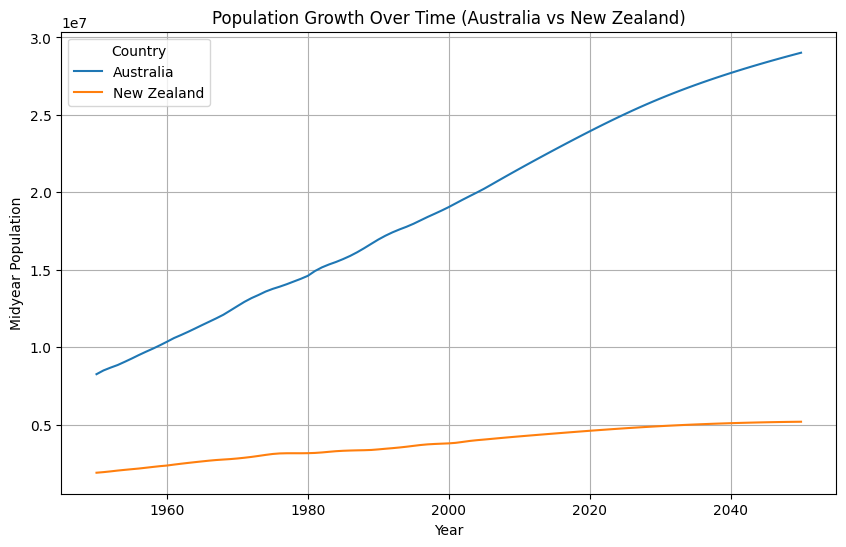

In [251]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=comp_pop, x='year', y='total_population', hue='country_name')

# Customize the plot
plt.title('Population Growth Over Time (Australia vs New Zealand)')
plt.xlabel('Year')
plt.ylabel('Midyear Population')
plt.grid(True)
plt.legend(title='Country', loc='upper left')

# Show the plot
plt.show()

### Top Countries with highest Life Expectancy larger than 25,000 km2.

In [131]:
sql = """
SELECT
  age.country_name, age.life_expectancy, size.country_area
FROM (
  SELECT
    country_name,
    life_expectancy
  FROM
    `bigquery-public-data.census_bureau_international.mortality_life_expectancy`
  WHERE
    year = 2016) age
INNER JOIN (
  SELECT
    country_name,
    country_area
  FROM
    `bigquery-public-data.census_bureau_international.country_names_area` where country_area > 25000) size
ON
  age.country_name = size.country_name
ORDER BY
  2 DESC
LIMIT
  10
"""
query_job = client.query(sql)
life2 = query_job.to_dataframe()
life2

,country_name,life_expectancy,country_area
0,Japan,85.00,364485.0
1,Iceland,83.02,100250.0
2,Switzerland,82.57,39997.0
3,"Korea, South",82.43,96920.0
4,Australia,82.23,7682300.0
5,Italy,82.20,294140.0
6,Sweden,82.06,410335.0
7,Canada,81.85,9093507.0
8,France,81.84,640427.0
9,Norway,81.78,304282.0


###  Life Expectancy vs Population Growth Rate for Australia

In [50]:
sql = """
SELECT mp.year, mp.midyear_population, mlex.life_expectancy, bdr.growth_rate
FROM `census_bureau_international.midyear_population` AS mp
JOIN `census_bureau_international.mortality_life_expectancy` AS mlex
ON mp.country_code = mlex.country_code AND mp.year = mlex.year
JOIN `census_bureau_international.birth_death_growth_rates` AS bdr
ON mp.country_code = bdr.country_code AND mp.year = bdr.year
WHERE mp.country_name = 'Australia'
ORDER BY mp.year
"""
query_job = client.query(sql)
life_gr = query_job.to_dataframe()
life_gr 

,year,midyear_population,life_expectancy,growth_rate
0,1986,15900415,75.62,1.385
1,1987,16136716,76.12,1.564
2,1988,16400734,76.17,1.681
3,1989,16680597,76.27,1.703
4,1990,16956242,76.86,1.576
...,...,...,...,...
60,2046,28519028,83.92,0.449
61,2047,28645887,83.96,0.439
62,2048,28770380,84.00,0.429
63,2049,28892628,84.03,0.419


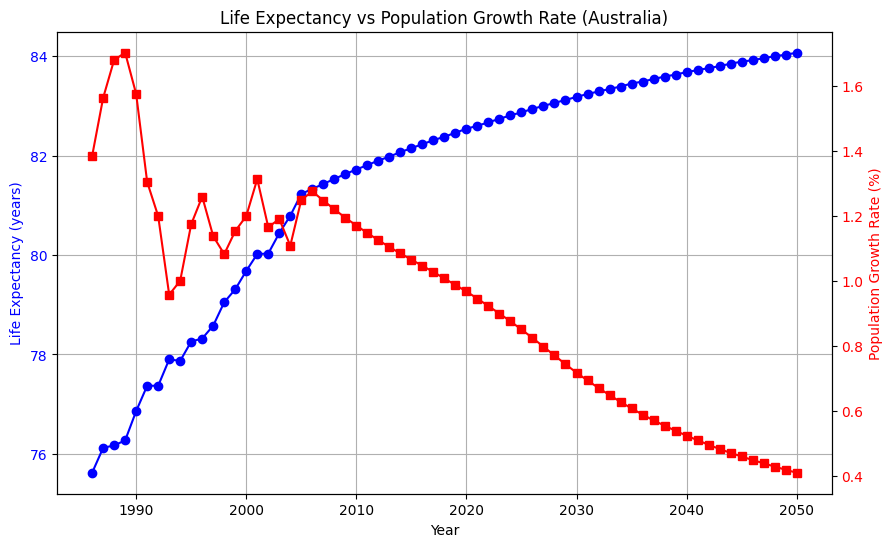

In [217]:
# Create the plot with dual y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot life expectancy on the primary y-axis
ax1.plot(life_gr['year'], life_gr['life_expectancy'], color='b', marker='o', label='Life Expectancy')
ax1.set_xlabel('Year')
ax1.set_ylabel('Life Expectancy (years)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis for population growth rate
ax2 = ax1.twinx()
ax2.plot(life_gr['year'], life_gr['growth_rate'], color='r', marker='s', label='Growth Rate')
ax2.set_ylabel('Population Growth Rate (%)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Set title and show grid
plt.title('Life Expectancy vs Population Growth Rate (Australia)')
ax1.grid(True)

# Display the plot
plt.show()


## Key Findings

 1. Population Distribution: Australia's 2024 population is heavily skewed towards the newborn age group, suggesting recent higher birth rates.

 2. Fertility Trends: Women aged 25-34 have the highest fertility rates, with younger age groups showing declining rates over time.

 3. Life Expectancy & Growth: No clear correlation between life expectancy and population growth was found, though high life expectancy often aligns with slower growth in developed nations.

 4. Gender Distribution: Females outnumber males in older age groups, reflecting global trends in life expectancy differences.

 5. Population Pyramids: Developed nations, like Australia, show more balanced or inverted population pyramids, while developing countries display traditional pyramid shapes.

 6. There's a good correlation between infant mortality rates and fertility in underdeveloped countries


<h2><center>END OF PRESENTATION</center></h2>
 <h2><center>🙏</center></h2>



---



---



> > > > > > > > > © 2024 Institute of Data


---



---



